In [10]:
import pandas as pd
import sqlite3
import shlex
import numpy as np
import collections
from matplotlib import pyplot as pl
import matplotlib.cm as cm
from ast import literal_eval

%matplotlib inline

def auto_cast(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            if s.lower() in ["false", "true"]:
                try:
                    return bool(s)
                except ValueError:
                    pass
    return str(s)

def cmd_parser(s, sort=False, template_dict=None):
    if '.py' in s:
        s = s.split('.py')[1]
    res = [x.split('=') if '=' in x else x.split(' ') for x in s.split(' --')[1:]]
    res = dict([(x[0], auto_cast(x[1])) if len(x) == 2 else (x[0], True) for x in res])
    if template_dict is not None:
        template_dict.update(res)
        res = template_dict        
    if sort:
        return collections.OrderedDict(sorted(res.items()))
    else:
        return res

eval_metrics = [ 'score',
                 'train_loss',
                 'reg_loss',
                 'estimated_error',
                 'centroid_norm',
                 'emb_norm',
                 'k_score',
                 'svm_score'
               ]

In [2]:
# Establish DB connection
conn = sqlite3.connect("/usr/stud/plapp/runnn2/runnn_data")
df = pd.read_sql_query("select * from tasks where score > 0;", conn)  # where status is 'done' and changed > '2017-11-05'
conn.close()
print("Loaded %d rows." % len(df))

Loaded 153 rows.


In [5]:
# Turn hyperparams into columns
hyperparams_df = df['params'].apply(literal_eval).apply(pd.Series)
params = hyperparams_df.columns.tolist()
df = df.join(hyperparams_df)

In [6]:
# Get list of datasets
datasets = [x for x in df.dataset.unique() if x == x]

In [11]:

print 'LEADERBOARD'
use_latest = 0
for dataset in datasets:
    ddf = df[df.dataset == dataset][-use_latest:]
    score_mean = ddf.score.mean() * 100
    score_std = ddf.score.std() * 100
    score_max = ddf.score.max() * 100
    score_max_taskid = ddf.ID_task[ddf.score.argmax()]
    print "%s:\t\t%.2f%%\t+/- %.2f (%d runs)\tbest: %.2f%% @ task %d" % (dataset[:6], score_mean, score_std, len(ddf), score_max, score_max_taskid)

LEADERBOARD
mnist:		19.16%	+/- 18.01 (153 runs)	best: 97.33% @ task 5


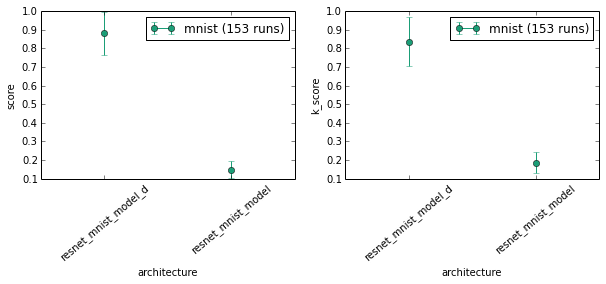

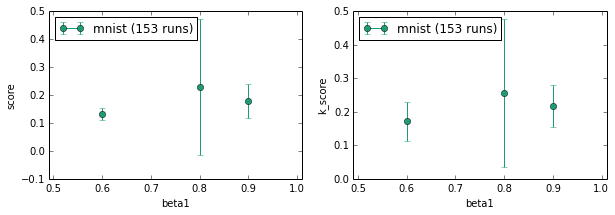

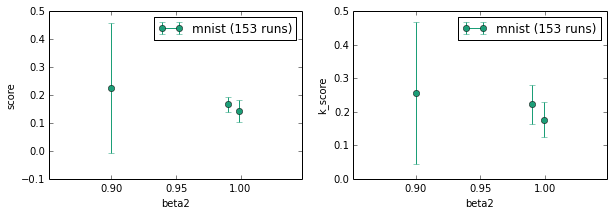

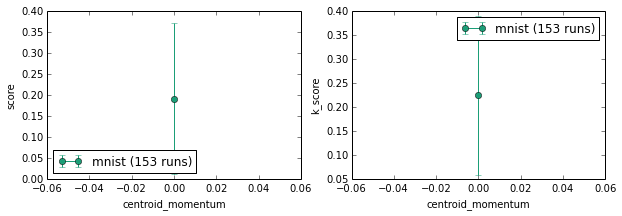

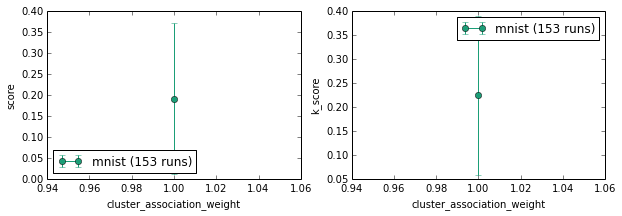

In [89]:
# Ablation study
not_plot = ['dataset', 'logdir', 'restore_checkpoint']
use_latest = 0  # how many runs to consider; 0=all
metrics_to_plot = ['score', 'k_score'] #eval_metrics

for param in params[:5]:
    if param in not_plot:
        continue
        
    is_numeric = True
    try:
        df[param].astype(float)
    except ValueError:
        is_numeric = False
    
    if is_numeric:
        xstd = df[param].std()
        xmin = df[param].min()-xstd
        xmax = df[param].max()+xstd
    else:
        pass  # will be set below

    colors = iter(cm.Dark2(np.linspace(0, 1, len(datasets))))

    for dataset in datasets:
        ddf = df[df.dataset == dataset][-use_latest:]
        label = "%s (%d runs)" % (dataset, len(ddf))
        c = next(colors)
        
        xs = ddf[param].unique()   
        xs = [i for i in xs if i==i]
        
        if not is_numeric:
            xs, xlabels = [], []
            for i, j in enumerate(ddf[param].unique()):
                xs.append(i)
                xlabels.append(str(j))
                
            xmin = -0.5
            xmax = len(xs) - 0.5
        
        fig, axs = pl.subplots(1, len(metrics_to_plot), figsize=(10,3))
        for ax, metric_to_plot in enumerate(metrics_to_plot):
            for x in xs:
                if is_numeric:
                    y = ddf[ddf[param] == x][metric_to_plot].astype(float)
                else:
                    y = ddf[ddf[param] == xlabels[x]][metric_to_plot].astype(float)
                yerr = y.std()
                y = y.mean()
                axs[ax].errorbar(x, y, yerr=yerr, label=label, color=c, marker='o')

            if not xmin == xmax:
                axs[ax].set_xlim((xmin, xmax))

            if not is_numeric:
                axs[ax].set_xticks(xs, minor=False)
                axs[ax].set_xticklabels(xlabels, minor=False, rotation=40)

            handles, labels = axs[ax].get_legend_handles_labels()
            newLabels, newHandles = [], []
            for handle, label in zip(handles, labels):
                if label not in newLabels:
                    newLabels.append(label)
                    newHandles.append(handle)
            axs[ax].legend(newHandles, newLabels, loc='best')
            axs[ax].set_xlabel(param)
            axs[ax].set_ylabel(metric_to_plot)
        pl.show()